# Deep Learning - Assignment 3 - Problem 2
### Ali Abbasi - 98105879

# Importing Libraries

In [1]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

import tqdm
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
torch.manual_seed(24)
np.random.seed(24)

# Datasets and Dataloaders

In [3]:
mean=torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
std=torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
normalize = T.Normalize(
   mean=mean,
   std=std
)
transform = T.Compose([T.ToTensor(), normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_size = int(0.2 * len(trainset))
train_size = len(trainset) - val_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


`mean` and `std` are what they have used to normalize Imagenet images in pytorch models.

If we had reshaped images to `(224, 224)`, we would have gotten a much better accuracy since resnet is trained on images of this size. But I am out of GPU memory, so I had to use smaller images. This (unfortunately) causes the teacher model to perform worse than the student model.

In [4]:
len(trainset), len(valset), len(testset)

(40000, 10000, 10000)

In [5]:
image_shape = trainset[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(testset.classes)
label_names = testset.classes
image_shape

torch.Size([3, 32, 32])

In [6]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
train_loader = DataLoader(trainset, 256, shuffle=True)
test_loader = DataLoader(testset, 256, shuffle=True)
val_loader = DataLoader(valset, 256, shuffle=True)

## Visualization

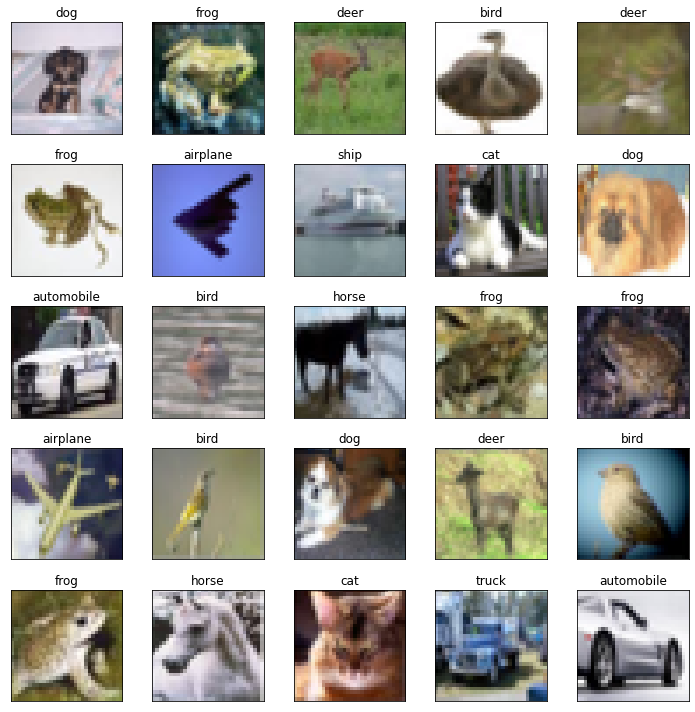

In [8]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flat
topil = T.ToPILImage()
for ax in axes:
    i = np.random.randint(len(trainset))
    x, y = trainset[i]
    x = x * std + mean
    img = topil(x)
    ax.imshow(img)
    ax.set_title(label_names[y])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# Models

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Teacher:

In [10]:
from torchvision.models.resnet import ResNet50_Weights
def get_teacher():
    teacher = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    teacher.fc = nn.Sequential(nn.Linear(teacher.fc.in_features, 256), nn.Linear(256, num_classes))
    teacher = teacher.to(device)
    return teacher

In [11]:
get_teacher()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Student:

In [12]:
def get_student():
    student = torchvision.models.resnet18(weights=None)
    student.fc = nn.Linear(student.fc.in_features, num_classes)
    student = student.to(device)
    return student

# Training Models

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [14]:
def one_epoch(models, loader, criterion, optimizer=None, epoch='', train=True, set_name='Train', metrics=None, verbose=True):
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    if len(models) == 2:
        model, teacher = models
        teacher.eval()
    else:
        model = models[0]
        teacher = None
    if train:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(train), tqdm.tqdm(enumerate(loader), total=len(loader), disable=not verbose) as pbar:
        for i, (x, y) in pbar:
            if train:
                optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            p_s = model(x)
            
            if teacher:
                with torch.no_grad():
                    p_t = teacher(x)
                loss = criterion(p_s, p_t, y)
            else:
                loss = criterion(p_s, y)

            if train:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * len(x)
            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / N:.3e}')

            y_pred = p_s.argmax(dim=-1)
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy_score(Y_pred, Y)
    if verbose:
        print(f'Accuracy of {set_name} set: {acc}')

    result = {'loss': total_loss, 'accuracy': acc}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})

    return result

In [15]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def clear_history():
    train_losses.clear()
    val_losses.clear()
    train_accuracies.clear()
    val_accuracies.clear()

In [16]:
def train_model(models, dataloaders, num_epochs, criterion, optimizer, scheduler=None, model_name='pytroch-model', verbose=True):
    train_loader, val_loader = dataloaders
    min_val_loss = np.inf
    for epoch in range(num_epochs):
        result = one_epoch(models, train_loader, criterion, optimizer, epoch, train=True, set_name='Train', verbose=verbose)
        train_loss = result['loss']
        train_acc = result['accuracy']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_result = one_epoch(models, val_loader, criterion, epoch=epoch, train=False, set_name='Validation', verbose=verbose)
        val_loss = val_result['loss']
        val_acc = val_result['accuracy']
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        if scheduler:
            scheduler.step(val_loss)
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(models[0].state_dict(), f'{model_name}.pt')
        if verbose:
            print('\n', '-' * 60)

    if verbose:
        plt.plot(train_losses, label='train')
        plt.plot(val_losses, label='val')
        plt.title('loss history of training and val sets')
        plt.legend()
        plt.show()

        plt.plot(train_accuracies, label='train')
        plt.plot(val_accuracies, label='val')
        plt.title('Accuracy history of training and val sets')
        plt.legend()
        plt.show()

    models[0].load_state_dict(torch.load(f'{model_name}.pt'))
    return models[0], min_val_loss

### Fine Tuning Teacher

In [17]:
clear_history()

# freezing all layers except the last one
teacher = get_teacher()
teacher.requires_grad_(False)
teacher.fc.requires_grad_(True)

In [ ]:
# Training config
lr = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, teacher.parameters()), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, threshold=0.0001, verbose=True)
# step_scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.2, verbose=True)

0: Train Loss: 1.130e+00: 100%|██████████| 157/157 [00:12<00:00, 12.21it/s]


Accuracy of Train set: 0.6125


0: Validation Loss: 1.344e+00: 100%|██████████| 40/40 [00:03<00:00, 12.06it/s]


Accuracy of Validation set: 0.5443
Epoch 00026: reducing learning rate of group 0 to 8.0000e-07.

 ------------------------------------------------------------


1: Train Loss: 1.127e+00: 100%|██████████| 157/157 [00:12<00:00, 12.35it/s]


Accuracy of Train set: 0.612625


1: Validation Loss: 1.347e+00: 100%|██████████| 40/40 [00:03<00:00, 12.09it/s]


Accuracy of Validation set: 0.5426

 ------------------------------------------------------------


2: Train Loss: 1.130e+00: 100%|██████████| 157/157 [00:13<00:00, 11.28it/s]


Accuracy of Train set: 0.6126


2: Validation Loss: 1.347e+00: 100%|██████████| 40/40 [00:03<00:00, 12.05it/s]


Accuracy of Validation set: 0.5449

 ------------------------------------------------------------


3: Train Loss: 1.133e+00: 100%|██████████| 157/157 [00:12<00:00, 12.34it/s]


Accuracy of Train set: 0.60985


3: Validation Loss: 1.344e+00: 100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Accuracy of Validation set: 0.5434
Epoch 00029: reducing learning rate of group 0 to 1.6000e-07.

 ------------------------------------------------------------


4: Train Loss: 1.133e+00: 100%|██████████| 157/157 [00:12<00:00, 12.42it/s]


Accuracy of Train set: 0.60895


4: Validation Loss: 1.344e+00: 100%|██████████| 40/40 [00:03<00:00, 11.90it/s]


Accuracy of Validation set: 0.5453

 ------------------------------------------------------------


5: Train Loss: 1.130e+00: 100%|██████████| 157/157 [00:13<00:00, 11.94it/s]


Accuracy of Train set: 0.61005


5: Validation Loss: 1.323e+00: 100%|██████████| 40/40 [00:03<00:00, 12.00it/s]


Accuracy of Validation set: 0.5468

 ------------------------------------------------------------


6: Train Loss: 1.132e+00: 100%|██████████| 157/157 [00:12<00:00, 12.43it/s]


Accuracy of Train set: 0.611825


6: Validation Loss: 1.347e+00: 100%|██████████| 40/40 [00:03<00:00, 12.35it/s]


Accuracy of Validation set: 0.5441

 ------------------------------------------------------------


7: Train Loss: 1.130e+00: 100%|██████████| 157/157 [00:12<00:00, 12.39it/s]


Accuracy of Train set: 0.610675


7: Validation Loss: 1.342e+00: 100%|██████████| 40/40 [00:03<00:00, 11.90it/s]


Accuracy of Validation set: 0.545

 ------------------------------------------------------------


8: Train Loss: 1.133e+00: 100%|██████████| 157/157 [00:12<00:00, 12.45it/s]


Accuracy of Train set: 0.610375


8: Validation Loss: 1.340e+00: 100%|██████████| 40/40 [00:03<00:00, 12.05it/s]


Accuracy of Validation set: 0.544
Epoch 00034: reducing learning rate of group 0 to 3.2000e-08.

 ------------------------------------------------------------


9: Train Loss: 1.131e+00: 100%|██████████| 157/157 [00:12<00:00, 12.49it/s]


Accuracy of Train set: 0.608975


9: Validation Loss: 1.343e+00: 100%|██████████| 40/40 [00:03<00:00, 12.11it/s]


Accuracy of Validation set: 0.5467

 ------------------------------------------------------------


10: Train Loss: 1.130e+00: 100%|██████████| 157/157 [00:12<00:00, 12.51it/s]


Accuracy of Train set: 0.6105


10: Validation Loss: 1.343e+00: 100%|██████████| 40/40 [00:04<00:00,  9.41it/s]


Accuracy of Validation set: 0.545

 ------------------------------------------------------------


11: Train Loss: 1.128e+00: 100%|██████████| 157/157 [00:13<00:00, 11.75it/s]


Accuracy of Train set: 0.610875


11: Validation Loss: 1.328e+00: 100%|██████████| 40/40 [00:03<00:00, 12.11it/s]


Accuracy of Validation set: 0.5455
Epoch 00037: reducing learning rate of group 0 to 6.4000e-09.

 ------------------------------------------------------------


12: Train Loss: 1.129e+00: 100%|██████████| 157/157 [00:12<00:00, 12.35it/s]


Accuracy of Train set: 0.6101


12: Validation Loss: 1.335e+00: 100%|██████████| 40/40 [00:03<00:00, 11.84it/s]


Accuracy of Validation set: 0.5474

 ------------------------------------------------------------


13: Train Loss: 1.129e+00: 100%|██████████| 157/157 [00:12<00:00, 12.51it/s]


Accuracy of Train set: 0.61195


13: Validation Loss: 1.349e+00: 100%|██████████| 40/40 [00:03<00:00, 12.00it/s]


Accuracy of Validation set: 0.5425

 ------------------------------------------------------------


14: Train Loss: 1.131e+00: 100%|██████████| 157/157 [00:12<00:00, 12.46it/s]


Accuracy of Train set: 0.6097


14: Validation Loss: 1.341e+00: 100%|██████████| 40/40 [00:03<00:00, 12.11it/s]


Accuracy of Validation set: 0.5411

 ------------------------------------------------------------


15: Train Loss: 1.127e+00: 100%|██████████| 157/157 [00:12<00:00, 12.50it/s]


Accuracy of Train set: 0.614175


15: Validation Loss: 1.349e+00: 100%|██████████| 40/40 [00:03<00:00, 12.20it/s]


Accuracy of Validation set: 0.545

 ------------------------------------------------------------


16: Train Loss: 1.130e+00: 100%|██████████| 157/157 [00:12<00:00, 12.49it/s]


Accuracy of Train set: 0.610525


16: Validation Loss: 1.347e+00: 100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Accuracy of Validation set: 0.544

 ------------------------------------------------------------


17: Train Loss: 1.130e+00: 100%|██████████| 157/157 [00:13<00:00, 11.85it/s]


Accuracy of Train set: 0.61035


17: Validation Loss: 1.348e+00: 100%|██████████| 40/40 [00:03<00:00, 11.78it/s]


Accuracy of Validation set: 0.5431

 ------------------------------------------------------------


18: Train Loss: 1.129e+00: 100%|██████████| 157/157 [00:12<00:00, 12.35it/s]


Accuracy of Train set: 0.60995


18: Validation Loss: 1.344e+00: 100%|██████████| 40/40 [00:03<00:00, 11.89it/s]


Accuracy of Validation set: 0.546

 ------------------------------------------------------------


19: Train Loss: 1.132e+00: 100%|██████████| 157/157 [00:12<00:00, 12.53it/s]


Accuracy of Train set: 0.61045


19: Validation Loss: 1.345e+00: 100%|██████████| 40/40 [00:03<00:00, 11.89it/s]


Accuracy of Validation set: 0.5456

 ------------------------------------------------------------


20: Train Loss: 1.131e+00: 100%|██████████| 157/157 [00:12<00:00, 12.48it/s]


Accuracy of Train set: 0.608425


20: Validation Loss: 1.339e+00: 100%|██████████| 40/40 [00:03<00:00, 12.17it/s]


Accuracy of Validation set: 0.5447

 ------------------------------------------------------------


21: Train Loss: 1.134e+00: 100%|██████████| 157/157 [00:12<00:00, 12.67it/s]


Accuracy of Train set: 0.608975


21: Validation Loss: 1.331e+00: 100%|██████████| 40/40 [00:03<00:00, 12.02it/s]


Accuracy of Validation set: 0.549

 ------------------------------------------------------------


22: Train Loss: 1.128e+00: 100%|██████████| 157/157 [00:12<00:00, 12.39it/s]


Accuracy of Train set: 0.611575


22: Validation Loss: 1.335e+00: 100%|██████████| 40/40 [00:03<00:00, 12.13it/s]


Accuracy of Validation set: 0.5456

 ------------------------------------------------------------


23: Train Loss: 1.129e+00: 100%|██████████| 157/157 [00:12<00:00, 12.25it/s]


Accuracy of Train set: 0.610175


23: Validation Loss: 1.328e+00: 100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Accuracy of Validation set: 0.5475

 ------------------------------------------------------------


24: Train Loss: 1.133e+00: 100%|██████████| 157/157 [00:12<00:00, 12.45it/s]


Accuracy of Train set: 0.6126


24: Validation Loss: 1.340e+00: 100%|██████████| 40/40 [00:03<00:00, 12.33it/s]


Accuracy of Validation set: 0.545

 ------------------------------------------------------------


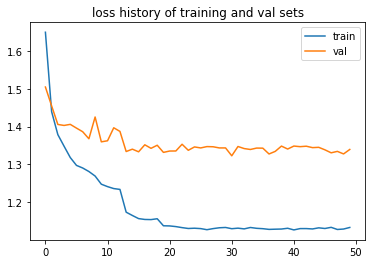

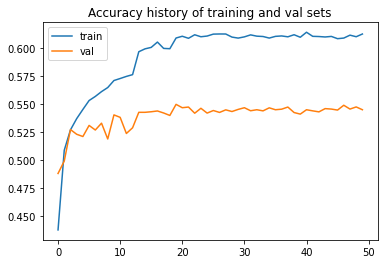

In [23]:
teacher, min_val_loss = train_model([teacher], [train_loader, val_loader], 25, criterion, optimizer, scheduler=scheduler)

#### Teacher's Training Results

In [24]:
average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}

: Test Loss: 1.324e+00: 100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Accuracy of Test set: 0.5493


{'loss': 1.3238388322830201,
 'accuracy': 0.5493,
 'precision': 0.5472464454507858,
 'recall': 0.5493,
 'f1': 0.5478826832665892}

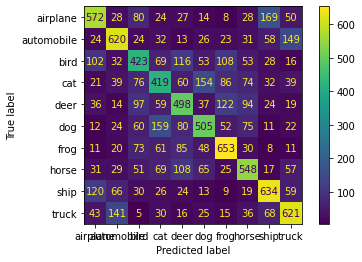

In [25]:
test_results = one_epoch([teacher], test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
test_results

: Validation Loss: 1.323e+00: 100%|██████████| 40/40 [00:03<00:00, 11.91it/s]


Accuracy of Validation set: 0.5468


{'loss': 1.3228676923751832,
 'accuracy': 0.5468,
 'precision': 0.5452224321673876,
 'recall': 0.5464764103175884,
 'f1': 0.5454338491096421}

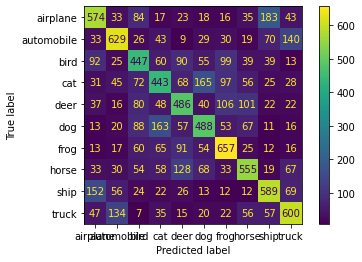

In [26]:
val_results = one_epoch([teacher], val_loader, criterion, train=False, set_name='Validation', metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
val_results

: Train Loss: 1.085e+00: 100%|██████████| 157/157 [00:12<00:00, 12.12it/s]


Accuracy of Train set: 0.627575


{'loss': 1.0853991954803466,
 'accuracy': 0.627575,
 'precision': 0.6263061024264994,
 'recall': 0.6276801335277884,
 'f1': 0.6265869149643938}

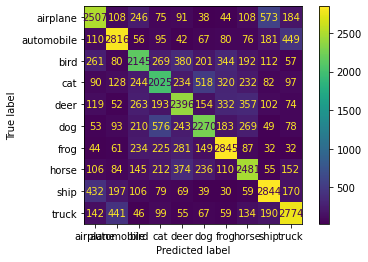

In [27]:
train_results = one_epoch([teacher], train_loader, criterion, train=False, set_name='Train', metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
train_results

### Training Student

In [76]:
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.9, T=2):
        super().__init__()
        self.alpha = alpha
        self.T = T
        self.kl_div = nn.KLDivLoss(log_target=True, reduction="batchmean")
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, p_s, p_t, y):
        teacher_loss = self.kl_div(F.log_softmax(p_s / self.T, dim=-1), F.log_softmax(p_t / self.T, dim=-1)) 
        student_loss = self.cross_entropy(p_s, y)
        return (1-self.alpha) * student_loss + self.alpha * self.T * self.T * teacher_loss

Hyperparameter Tuning:

In [ ]:
best_val_loss = np.inf
best_alpha = 0
best_T = 0
best_lr = 0

In [78]:
for i in range(10):
    alpha = np.random.uniform(0.5, 1)
    T = np.random.uniform(1, 10)
    lr = np.power(10, np.random.uniform(-4, -2))
    print(f'({i}) alpha={alpha:.2f}, T={T:.2f}, min_val_loss={min_val_loss:.4f} lr={best_lr:.4f}')

    clear_history()
    student = get_student()
    criterion = DistillationLoss(alpha, T)
    optimizer = optim.Adam(student.parameters(), lr=lr)
    student, min_val_loss = train_model([student, teacher], [train_loader, val_loader], 8, criterion, optimizer, verbose=False)
    if min_val_loss < best_val_loss:
        best_val_loss = min_val_loss
        best_alpha = alpha
        best_T = T
        best_lr = lr

print(f'Best alpha={best_alpha:.2f}, T={best_T:.2f}, min_val_loss={best_val_loss:.4f}, lr={best_lr:.4f}')

alpha=0.97, T=9.28, min_val_loss=1.1670
alpha=0.97, T=1.98, min_val_loss=0.9794
alpha=0.68, T=9.44, min_val_loss=1.3176
alpha=0.77, T=4.48, min_val_loss=1.1626
alpha=0.62, T=5.72, min_val_loss=1.1481
alpha=0.88, T=3.37, min_val_loss=1.0450
alpha=0.73, T=6.26, min_val_loss=1.1169
alpha=0.91, T=2.47, min_val_loss=0.9654
alpha=0.92, T=3.61, min_val_loss=1.2414
alpha=1.00, T=4.23, min_val_loss=1.0966
Best alpha=0.91, T=2.47, min_val_loss=0.9654, lr=0.0019


Training Student:

0: Train Loss: 1.241e+00: 100%|██████████| 157/157 [00:18<00:00,  8.38it/s]


Accuracy of Train set: 0.457775


0: Validation Loss: 1.218e+00: 100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Accuracy of Validation set: 0.4881

 ------------------------------------------------------------


1: Train Loss: 9.993e-01: 100%|██████████| 157/157 [00:17<00:00,  8.90it/s]


Accuracy of Train set: 0.58025


1: Validation Loss: 1.051e+00: 100%|██████████| 40/40 [00:03<00:00, 12.03it/s]


Accuracy of Validation set: 0.5741

 ------------------------------------------------------------


2: Train Loss: 9.092e-01: 100%|██████████| 157/157 [00:17<00:00,  8.87it/s]


Accuracy of Train set: 0.632075


2: Validation Loss: 1.013e+00: 100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Accuracy of Validation set: 0.6147

 ------------------------------------------------------------


3: Train Loss: 8.434e-01: 100%|██████████| 157/157 [00:17<00:00,  8.79it/s]


Accuracy of Train set: 0.6573


3: Validation Loss: 1.068e+00: 100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Accuracy of Validation set: 0.5985

 ------------------------------------------------------------


4: Train Loss: 8.084e-01: 100%|██████████| 157/157 [00:18<00:00,  8.37it/s]


Accuracy of Train set: 0.67185


4: Validation Loss: 9.567e-01: 100%|██████████| 40/40 [00:03<00:00, 12.03it/s]


Accuracy of Validation set: 0.638

 ------------------------------------------------------------


5: Train Loss: 7.631e-01: 100%|██████████| 157/157 [00:17<00:00,  8.87it/s]


Accuracy of Train set: 0.687925


5: Validation Loss: 1.038e+00: 100%|██████████| 40/40 [00:03<00:00, 11.96it/s]


Accuracy of Validation set: 0.6135

 ------------------------------------------------------------


6: Train Loss: 7.216e-01: 100%|██████████| 157/157 [00:17<00:00,  8.80it/s]


Accuracy of Train set: 0.6984


6: Validation Loss: 9.670e-01: 100%|██████████| 40/40 [00:03<00:00, 11.85it/s]


Accuracy of Validation set: 0.6407

 ------------------------------------------------------------


7: Train Loss: 6.768e-01: 100%|██████████| 157/157 [00:17<00:00,  8.82it/s]


Accuracy of Train set: 0.703825


7: Validation Loss: 9.555e-01: 100%|██████████| 40/40 [00:03<00:00, 11.99it/s]


Accuracy of Validation set: 0.6551

 ------------------------------------------------------------


8: Train Loss: 6.283e-01: 100%|██████████| 157/157 [00:17<00:00,  8.78it/s]


Accuracy of Train set: 0.705875


8: Validation Loss: 9.959e-01: 100%|██████████| 40/40 [00:03<00:00, 12.13it/s]


Accuracy of Validation set: 0.6517

 ------------------------------------------------------------


9: Train Loss: 5.898e-01: 100%|██████████| 157/157 [00:17<00:00,  8.83it/s]


Accuracy of Train set: 0.7116


9: Validation Loss: 9.724e-01: 100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Accuracy of Validation set: 0.6537

 ------------------------------------------------------------


10: Train Loss: 5.442e-01: 100%|██████████| 157/157 [00:18<00:00,  8.54it/s]


Accuracy of Train set: 0.7137


10: Validation Loss: 1.008e+00: 100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Accuracy of Validation set: 0.6455

 ------------------------------------------------------------


11: Train Loss: 5.014e-01: 100%|██████████| 157/157 [00:17<00:00,  8.85it/s]


Accuracy of Train set: 0.7145


11: Validation Loss: 9.928e-01: 100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


Accuracy of Validation set: 0.6442

 ------------------------------------------------------------


12: Train Loss: 4.655e-01: 100%|██████████| 157/157 [00:17<00:00,  8.86it/s]


Accuracy of Train set: 0.715125


12: Validation Loss: 1.035e+00: 100%|██████████| 40/40 [00:03<00:00, 12.20it/s]


Accuracy of Validation set: 0.6307

 ------------------------------------------------------------


13: Train Loss: 4.284e-01: 100%|██████████| 157/157 [00:17<00:00,  8.81it/s]


Accuracy of Train set: 0.7155


13: Validation Loss: 9.794e-01: 100%|██████████| 40/40 [00:03<00:00, 12.11it/s]


Accuracy of Validation set: 0.6534

 ------------------------------------------------------------


14: Train Loss: 3.981e-01: 100%|██████████| 157/157 [00:17<00:00,  8.84it/s]


Accuracy of Train set: 0.715125


14: Validation Loss: 1.052e+00: 100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Accuracy of Validation set: 0.6352

 ------------------------------------------------------------


15: Train Loss: 3.657e-01: 100%|██████████| 157/157 [00:17<00:00,  8.82it/s]


Accuracy of Train set: 0.717075


15: Validation Loss: 1.019e+00: 100%|██████████| 40/40 [00:03<00:00, 11.86it/s]


Accuracy of Validation set: 0.6404

 ------------------------------------------------------------


16: Train Loss: 3.429e-01: 100%|██████████| 157/157 [00:17<00:00,  8.77it/s]


Accuracy of Train set: 0.714575


16: Validation Loss: 1.029e+00: 100%|██████████| 40/40 [00:03<00:00, 11.86it/s]


Accuracy of Validation set: 0.6411

 ------------------------------------------------------------


17: Train Loss: 3.225e-01: 100%|██████████| 157/157 [00:19<00:00,  7.98it/s]


Accuracy of Train set: 0.716425


17: Validation Loss: 1.029e+00: 100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Accuracy of Validation set: 0.643

 ------------------------------------------------------------


18: Train Loss: 2.970e-01: 100%|██████████| 157/157 [00:17<00:00,  8.81it/s]


Accuracy of Train set: 0.721375


18: Validation Loss: 1.023e+00: 100%|██████████| 40/40 [00:03<00:00, 12.02it/s]


Accuracy of Validation set: 0.6467

 ------------------------------------------------------------


19: Train Loss: 2.790e-01: 100%|██████████| 157/157 [00:17<00:00,  8.83it/s]


Accuracy of Train set: 0.71785


19: Validation Loss: 1.025e+00: 100%|██████████| 40/40 [00:03<00:00, 12.17it/s]


Accuracy of Validation set: 0.6501

 ------------------------------------------------------------


20: Train Loss: 2.625e-01: 100%|██████████| 157/157 [00:18<00:00,  8.56it/s]


Accuracy of Train set: 0.717225


20: Validation Loss: 1.047e+00: 100%|██████████| 40/40 [00:03<00:00, 12.34it/s]


Accuracy of Validation set: 0.651

 ------------------------------------------------------------


21: Train Loss: 2.503e-01: 100%|██████████| 157/157 [00:17<00:00,  8.81it/s]


Accuracy of Train set: 0.718575


21: Validation Loss: 1.046e+00: 100%|██████████| 40/40 [00:03<00:00, 11.91it/s]


Accuracy of Validation set: 0.6528

 ------------------------------------------------------------


22: Train Loss: 2.412e-01: 100%|██████████| 157/157 [00:17<00:00,  8.88it/s]


Accuracy of Train set: 0.717975


22: Validation Loss: 1.024e+00: 100%|██████████| 40/40 [00:03<00:00, 12.12it/s]


Accuracy of Validation set: 0.6486

 ------------------------------------------------------------


23: Train Loss: 2.284e-01: 100%|██████████| 157/157 [00:17<00:00,  8.87it/s]


Accuracy of Train set: 0.718925


23: Validation Loss: 1.020e+00: 100%|██████████| 40/40 [00:03<00:00, 12.02it/s]


Accuracy of Validation set: 0.652

 ------------------------------------------------------------


24: Train Loss: 2.224e-01: 100%|██████████| 157/157 [00:17<00:00,  8.81it/s]


Accuracy of Train set: 0.71905


24: Validation Loss: 1.024e+00: 100%|██████████| 40/40 [00:03<00:00, 11.74it/s]


Accuracy of Validation set: 0.6497

 ------------------------------------------------------------


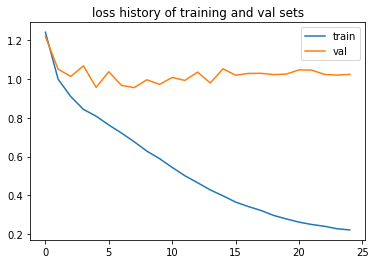

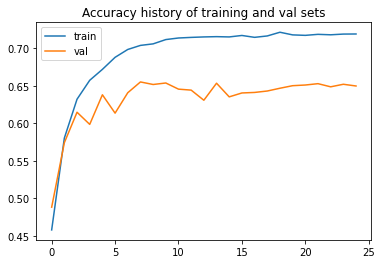

In [96]:
clear_history()
student = get_student()
criterion = DistillationLoss(best_alpha, best_T)
optimizer = optim.Adam(student.parameters(), lr=best_lr)
student, min_val_loss = train_model([student, teacher], [train_loader, val_loader], 25, criterion, optimizer)

#### Student's Training Results

In [97]:
criterion = nn.CrossEntropyLoss()

: Test Loss: 1.050e+00: 100%|██████████| 40/40 [00:02<00:00, 15.76it/s]


Accuracy of Test set: 0.6575


{'loss': 1.049641090297699,
 'accuracy': 0.6575,
 'precision': 0.6627962358577995,
 'recall': 0.6575,
 'f1': 0.6559739000110889}

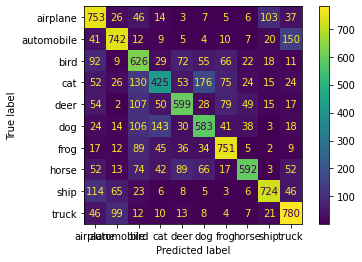

In [98]:
test_results = one_epoch([student], test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
test_results

: Validation Loss: 1.047e+00: 100%|██████████| 40/40 [00:02<00:00, 14.72it/s]


Accuracy of Validation set: 0.6551


{'loss': 1.0465889964103698,
 'accuracy': 0.6551,
 'precision': 0.6591032247902406,
 'recall': 0.6549307766916903,
 'f1': 0.6531425358462292}

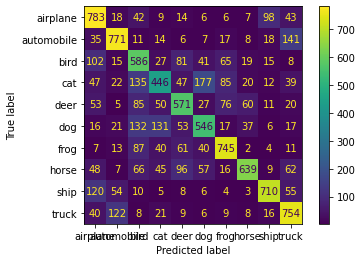

In [99]:
val_results = one_epoch([student], val_loader, criterion, train=False, set_name='Validation', metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
val_results

: Train Loss: 9.361e-01: 100%|██████████| 157/157 [00:10<00:00, 14.38it/s]


Accuracy of Train set: 0.706675


{'loss': 0.9360727922439576,
 'accuracy': 0.706675,
 'precision': 0.7112903233805073,
 'recall': 0.7066472558267398,
 'f1': 0.7057254302477086}

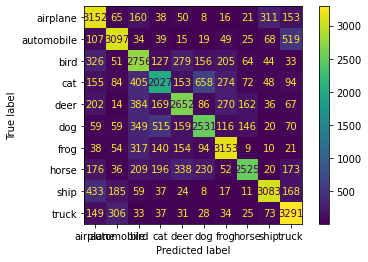

In [100]:
train_results = one_epoch([student], train_loader, criterion, train=False, set_name='Train', metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
train_results

### Training Student from Scratch

0: Train Loss: 1.467e+00: 100%|██████████| 157/157 [00:14<00:00, 11.10it/s]


Accuracy of Train set: 0.46985


0: Validation Loss: 1.294e+00: 100%|██████████| 40/40 [00:02<00:00, 16.43it/s]


Accuracy of Validation set: 0.5406

 ------------------------------------------------------------


1: Train Loss: 1.070e+00: 100%|██████████| 157/157 [00:13<00:00, 11.33it/s]


Accuracy of Train set: 0.6172


1: Validation Loss: 1.158e+00: 100%|██████████| 40/40 [00:02<00:00, 16.36it/s]


Accuracy of Validation set: 0.5931

 ------------------------------------------------------------


2: Train Loss: 8.569e-01: 100%|██████████| 157/157 [00:14<00:00, 10.88it/s]


Accuracy of Train set: 0.69655


2: Validation Loss: 1.102e+00: 100%|██████████| 40/40 [00:04<00:00,  9.90it/s]


Accuracy of Validation set: 0.6193

 ------------------------------------------------------------


3: Train Loss: 6.938e-01: 100%|██████████| 157/157 [00:17<00:00,  8.94it/s]


Accuracy of Train set: 0.75615


3: Validation Loss: 1.006e+00: 100%|██████████| 40/40 [00:02<00:00, 13.37it/s]


Accuracy of Validation set: 0.669

 ------------------------------------------------------------


4: Train Loss: 5.456e-01: 100%|██████████| 157/157 [00:15<00:00,  9.90it/s]


Accuracy of Train set: 0.8095


4: Validation Loss: 1.051e+00: 100%|██████████| 40/40 [00:03<00:00, 11.18it/s]


Accuracy of Validation set: 0.6639

 ------------------------------------------------------------


5: Train Loss: 4.313e-01: 100%|██████████| 157/157 [00:14<00:00, 10.52it/s]


Accuracy of Train set: 0.846275


5: Validation Loss: 1.056e+00: 100%|██████████| 40/40 [00:02<00:00, 15.97it/s]


Accuracy of Validation set: 0.6779

 ------------------------------------------------------------


6: Train Loss: 3.293e-01: 100%|██████████| 157/157 [00:13<00:00, 11.50it/s]


Accuracy of Train set: 0.88315


6: Validation Loss: 1.158e+00: 100%|██████████| 40/40 [00:02<00:00, 16.65it/s]


Accuracy of Validation set: 0.6633

 ------------------------------------------------------------


7: Train Loss: 2.559e-01: 100%|██████████| 157/157 [00:13<00:00, 11.43it/s]


Accuracy of Train set: 0.908875


7: Validation Loss: 1.222e+00: 100%|██████████| 40/40 [00:04<00:00,  8.09it/s]


Accuracy of Validation set: 0.6781

 ------------------------------------------------------------


8: Train Loss: 2.036e-01: 100%|██████████| 157/157 [00:15<00:00, 10.36it/s]


Accuracy of Train set: 0.92825


8: Validation Loss: 1.395e+00: 100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Accuracy of Validation set: 0.6659

 ------------------------------------------------------------


9: Train Loss: 1.620e-01: 100%|██████████| 157/157 [00:13<00:00, 11.25it/s]


Accuracy of Train set: 0.942775


9: Validation Loss: 1.364e+00: 100%|██████████| 40/40 [00:02<00:00, 16.80it/s]


Accuracy of Validation set: 0.6837

 ------------------------------------------------------------


10: Train Loss: 1.263e-01: 100%|██████████| 157/157 [00:13<00:00, 11.38it/s]


Accuracy of Train set: 0.957275


10: Validation Loss: 1.416e+00: 100%|██████████| 40/40 [00:05<00:00,  7.18it/s]


Accuracy of Validation set: 0.694

 ------------------------------------------------------------


11: Train Loss: 1.281e-01: 100%|██████████| 157/157 [00:16<00:00,  9.61it/s]


Accuracy of Train set: 0.9548


11: Validation Loss: 1.488e+00: 100%|██████████| 40/40 [00:03<00:00, 11.97it/s]


Accuracy of Validation set: 0.6615

 ------------------------------------------------------------


12: Train Loss: 1.119e-01: 100%|██████████| 157/157 [00:13<00:00, 11.45it/s]


Accuracy of Train set: 0.960675


12: Validation Loss: 1.479e+00: 100%|██████████| 40/40 [00:02<00:00, 16.42it/s]


Accuracy of Validation set: 0.6893

 ------------------------------------------------------------


13: Train Loss: 9.705e-02: 100%|██████████| 157/157 [00:14<00:00, 10.81it/s]


Accuracy of Train set: 0.966325


13: Validation Loss: 1.522e+00: 100%|██████████| 40/40 [00:02<00:00, 15.83it/s]


Accuracy of Validation set: 0.6899

 ------------------------------------------------------------


14: Train Loss: 8.731e-02: 100%|██████████| 157/157 [00:13<00:00, 11.47it/s]


Accuracy of Train set: 0.96885


14: Validation Loss: 1.543e+00: 100%|██████████| 40/40 [00:02<00:00, 16.29it/s]


Accuracy of Validation set: 0.6917

 ------------------------------------------------------------


15: Train Loss: 8.343e-02: 100%|██████████| 157/157 [00:13<00:00, 11.40it/s]


Accuracy of Train set: 0.971175


15: Validation Loss: 1.595e+00: 100%|██████████| 40/40 [00:02<00:00, 15.96it/s]


Accuracy of Validation set: 0.6878

 ------------------------------------------------------------


16: Train Loss: 7.727e-02: 100%|██████████| 157/157 [00:14<00:00, 11.10it/s]


Accuracy of Train set: 0.97275


16: Validation Loss: 1.572e+00: 100%|██████████| 40/40 [00:02<00:00, 16.43it/s]


Accuracy of Validation set: 0.6952

 ------------------------------------------------------------


17: Train Loss: 6.697e-02: 100%|██████████| 157/157 [00:14<00:00, 11.17it/s]


Accuracy of Train set: 0.976625


17: Validation Loss: 1.602e+00: 100%|██████████| 40/40 [00:02<00:00, 15.80it/s]


Accuracy of Validation set: 0.6954

 ------------------------------------------------------------


18: Train Loss: 6.190e-02: 100%|██████████| 157/157 [00:14<00:00, 11.08it/s]


Accuracy of Train set: 0.9785


18: Validation Loss: 1.634e+00: 100%|██████████| 40/40 [00:02<00:00, 16.45it/s]


Accuracy of Validation set: 0.6875

 ------------------------------------------------------------


19: Train Loss: 7.995e-02: 100%|██████████| 157/157 [00:13<00:00, 11.22it/s]


Accuracy of Train set: 0.972475


19: Validation Loss: 1.611e+00: 100%|██████████| 40/40 [00:02<00:00, 16.34it/s]


Accuracy of Validation set: 0.6919

 ------------------------------------------------------------


20: Train Loss: 8.033e-02: 100%|██████████| 157/157 [00:13<00:00, 11.38it/s]


Accuracy of Train set: 0.97255


20: Validation Loss: 1.570e+00: 100%|██████████| 40/40 [00:02<00:00, 16.00it/s]


Accuracy of Validation set: 0.7004

 ------------------------------------------------------------


21: Train Loss: 5.548e-02: 100%|██████████| 157/157 [00:13<00:00, 11.38it/s]


Accuracy of Train set: 0.9802


21: Validation Loss: 1.630e+00: 100%|██████████| 40/40 [00:02<00:00, 16.20it/s]


Accuracy of Validation set: 0.6994

 ------------------------------------------------------------


22: Train Loss: 6.369e-02: 100%|██████████| 157/157 [00:14<00:00, 10.88it/s]


Accuracy of Train set: 0.977025


22: Validation Loss: 1.643e+00: 100%|██████████| 40/40 [00:02<00:00, 16.06it/s]


Accuracy of Validation set: 0.6921

 ------------------------------------------------------------


23: Train Loss: 5.008e-02: 100%|██████████| 157/157 [00:13<00:00, 11.35it/s]


Accuracy of Train set: 0.983025


23: Validation Loss: 1.684e+00: 100%|██████████| 40/40 [00:02<00:00, 15.65it/s]


Accuracy of Validation set: 0.6896

 ------------------------------------------------------------


24: Train Loss: 6.211e-02: 100%|██████████| 157/157 [00:13<00:00, 11.44it/s]


Accuracy of Train set: 0.977575


24: Validation Loss: 1.619e+00: 100%|██████████| 40/40 [00:02<00:00, 16.26it/s]


Accuracy of Validation set: 0.6943

 ------------------------------------------------------------


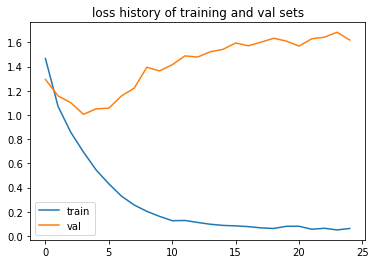

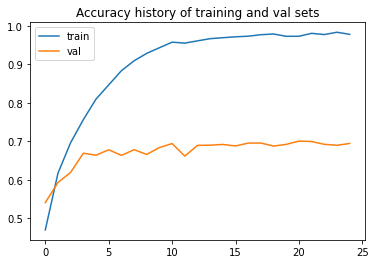

In [101]:
clear_history()
student = get_student()
criterion = nn.CrossEntropyLoss()
lr = 5e-4
optimizer = optim.Adam(student.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, threshold=0.0001, verbose=True)
student, min_val_loss = train_model([student], [train_loader, val_loader], 25, criterion, optimizer, model_name='student-scratch')

#### Student's Training from Scratch Results

: Test Loss: 1.022e+00: 100%|██████████| 40/40 [00:02<00:00, 15.02it/s]


Accuracy of Test set: 0.6511


{'loss': 1.0224498097419739,
 'accuracy': 0.6511,
 'precision': 0.6564605557858476,
 'recall': 0.6511,
 'f1': 0.6457107407357792}

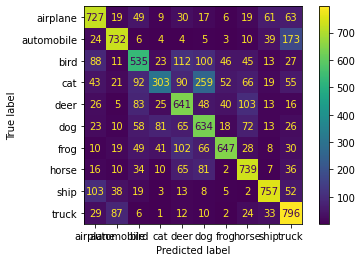

In [102]:
test_results = one_epoch([student], test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
test_results

: Validation Loss: 1.006e+00: 100%|██████████| 40/40 [00:02<00:00, 14.38it/s]


Accuracy of Validation set: 0.669


{'loss': 1.0056395278930663,
 'accuracy': 0.669,
 'precision': 0.67492147490374,
 'recall': 0.6691572900889158,
 'f1': 0.6630593804045447}

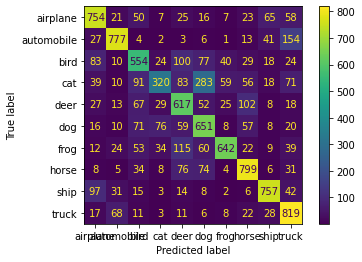

In [103]:
val_results = one_epoch([student], val_loader, criterion, train=False, set_name='Validation', metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
val_results

: Train Loss: 5.614e-01: 100%|██████████| 157/157 [00:10<00:00, 14.74it/s]


Accuracy of Train set: 0.80655


{'loss': 0.5614018567085266,
 'accuracy': 0.80655,
 'precision': 0.8131280268199058,
 'recall': 0.8064566095534639,
 'f1': 0.8030544312863015}

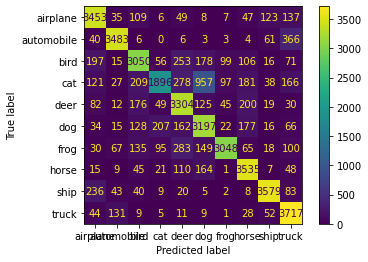

In [104]:
train_results = one_epoch([student], train_loader, criterion, train=False, set_name='Train', metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
train_results

### Finetuning all layers of teacher:

In [105]:
clear_history()
teacher = get_teacher()

In [106]:
# Training config
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, teacher.parameters()), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, threshold=0.0001, verbose=True)
# step_scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.2, verbose=True)

0: Train Loss: 9.739e-01: 100%|██████████| 157/157 [00:24<00:00,  6.40it/s]


Accuracy of Train set: 0.67245


0: Validation Loss: 6.799e-01: 100%|██████████| 40/40 [00:03<00:00, 12.77it/s]


Accuracy of Validation set: 0.7614

 ------------------------------------------------------------


1: Train Loss: 5.551e-01: 100%|██████████| 157/157 [00:26<00:00,  5.84it/s]


Accuracy of Train set: 0.812925


1: Validation Loss: 6.852e-01: 100%|██████████| 40/40 [00:04<00:00,  8.83it/s]


Accuracy of Validation set: 0.7714

 ------------------------------------------------------------


2: Train Loss: 4.408e-01: 100%|██████████| 157/157 [00:24<00:00,  6.36it/s]


Accuracy of Train set: 0.852425


2: Validation Loss: 6.187e-01: 100%|██████████| 40/40 [00:03<00:00, 13.04it/s]


Accuracy of Validation set: 0.7962

 ------------------------------------------------------------


3: Train Loss: 3.015e-01: 100%|██████████| 157/157 [00:24<00:00,  6.51it/s]


Accuracy of Train set: 0.898575


3: Validation Loss: 6.386e-01: 100%|██████████| 40/40 [00:03<00:00, 12.69it/s]


Accuracy of Validation set: 0.7947

 ------------------------------------------------------------


4: Train Loss: 2.572e-01: 100%|██████████| 157/157 [00:24<00:00,  6.52it/s]


Accuracy of Train set: 0.912575


4: Validation Loss: 7.083e-01: 100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


Accuracy of Validation set: 0.7949

 ------------------------------------------------------------


5: Train Loss: 2.310e-01: 100%|██████████| 157/157 [00:24<00:00,  6.50it/s]


Accuracy of Train set: 0.922025


5: Validation Loss: 6.198e-01: 100%|██████████| 40/40 [00:03<00:00, 13.01it/s]


Accuracy of Validation set: 0.8172
Epoch 00006: reducing learning rate of group 0 to 2.0000e-04.

 ------------------------------------------------------------


6: Train Loss: 6.397e-02: 100%|██████████| 157/157 [00:24<00:00,  6.49it/s]


Accuracy of Train set: 0.9807


6: Validation Loss: 5.655e-01: 100%|██████████| 40/40 [00:03<00:00, 12.92it/s]


Accuracy of Validation set: 0.8483

 ------------------------------------------------------------


7: Train Loss: 1.725e-02: 100%|██████████| 157/157 [00:24<00:00,  6.47it/s]


Accuracy of Train set: 0.99545


7: Validation Loss: 6.176e-01: 100%|██████████| 40/40 [00:04<00:00,  9.10it/s]


Accuracy of Validation set: 0.8505

 ------------------------------------------------------------


8: Train Loss: 7.668e-03: 100%|██████████| 157/157 [00:24<00:00,  6.41it/s]


Accuracy of Train set: 0.998875


8: Validation Loss: 6.707e-01: 100%|██████████| 40/40 [00:03<00:00, 12.84it/s]


Accuracy of Validation set: 0.8499

 ------------------------------------------------------------


9: Train Loss: 2.430e-02: 100%|██████████| 157/157 [00:24<00:00,  6.35it/s]


Accuracy of Train set: 0.993


9: Validation Loss: 7.243e-01: 100%|██████████| 40/40 [00:03<00:00, 12.91it/s]


Accuracy of Validation set: 0.848
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.

 ------------------------------------------------------------


10: Train Loss: 5.213e-03: 100%|██████████| 157/157 [00:25<00:00,  6.15it/s]


Accuracy of Train set: 0.998625


10: Validation Loss: 7.289e-01: 100%|██████████| 40/40 [00:03<00:00, 12.79it/s]


Accuracy of Validation set: 0.8507

 ------------------------------------------------------------


11: Train Loss: 3.030e-03: 100%|██████████| 157/157 [00:24<00:00,  6.42it/s]


Accuracy of Train set: 0.99965


11: Validation Loss: 7.348e-01: 100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


Accuracy of Validation set: 0.8519

 ------------------------------------------------------------


12: Train Loss: 2.379e-03: 100%|██████████| 157/157 [00:24<00:00,  6.45it/s]


Accuracy of Train set: 0.99965


12: Validation Loss: 7.500e-01: 100%|██████████| 40/40 [00:03<00:00, 12.76it/s]


Accuracy of Validation set: 0.8525
Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.

 ------------------------------------------------------------


13: Train Loss: 1.844e-03: 100%|██████████| 157/157 [00:24<00:00,  6.47it/s]


Accuracy of Train set: 0.99985


13: Validation Loss: 7.589e-01: 100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


Accuracy of Validation set: 0.8525

 ------------------------------------------------------------


14: Train Loss: 2.143e-03: 100%|██████████| 157/157 [00:24<00:00,  6.48it/s]


Accuracy of Train set: 0.999675


14: Validation Loss: 7.555e-01: 100%|██████████| 40/40 [00:03<00:00, 12.44it/s]


Accuracy of Validation set: 0.8503

 ------------------------------------------------------------


15: Train Loss: 1.748e-03: 100%|██████████| 157/157 [00:24<00:00,  6.48it/s]


Accuracy of Train set: 0.999875


15: Validation Loss: 7.542e-01: 100%|██████████| 40/40 [00:03<00:00, 12.88it/s]


Accuracy of Validation set: 0.8523
Epoch 00016: reducing learning rate of group 0 to 1.6000e-06.

 ------------------------------------------------------------


16: Train Loss: 1.672e-03: 100%|██████████| 157/157 [00:24<00:00,  6.48it/s]


Accuracy of Train set: 0.999875


16: Validation Loss: 7.566e-01: 100%|██████████| 40/40 [00:03<00:00, 12.99it/s]


Accuracy of Validation set: 0.8508

 ------------------------------------------------------------


17: Train Loss: 1.708e-03: 100%|██████████| 157/157 [00:24<00:00,  6.45it/s]


Accuracy of Train set: 0.999825


17: Validation Loss: 7.595e-01: 100%|██████████| 40/40 [00:03<00:00, 12.82it/s]


Accuracy of Validation set: 0.8525

 ------------------------------------------------------------


18: Train Loss: 1.728e-03: 100%|██████████| 157/157 [00:24<00:00,  6.48it/s]


Accuracy of Train set: 0.999875


18: Validation Loss: 7.601e-01: 100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


Accuracy of Validation set: 0.8532
Epoch 00019: reducing learning rate of group 0 to 3.2000e-07.

 ------------------------------------------------------------


19: Train Loss: 1.670e-03: 100%|██████████| 157/157 [00:24<00:00,  6.51it/s]


Accuracy of Train set: 0.9998


19: Validation Loss: 7.525e-01: 100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


Accuracy of Validation set: 0.8532

 ------------------------------------------------------------


20: Train Loss: 1.582e-03: 100%|██████████| 157/157 [00:24<00:00,  6.40it/s]


Accuracy of Train set: 0.9999


20: Validation Loss: 7.578e-01: 100%|██████████| 40/40 [00:03<00:00, 12.78it/s]


Accuracy of Validation set: 0.8527

 ------------------------------------------------------------


21: Train Loss: 1.509e-03: 100%|██████████| 157/157 [00:24<00:00,  6.29it/s]


Accuracy of Train set: 0.999925


21: Validation Loss: 7.635e-01: 100%|██████████| 40/40 [00:03<00:00, 12.97it/s]


Accuracy of Validation set: 0.853
Epoch 00022: reducing learning rate of group 0 to 6.4000e-08.

 ------------------------------------------------------------


22: Train Loss: 1.532e-03: 100%|██████████| 157/157 [00:24<00:00,  6.49it/s]


Accuracy of Train set: 0.999925


22: Validation Loss: 7.561e-01: 100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


Accuracy of Validation set: 0.8541

 ------------------------------------------------------------


23: Train Loss: 1.811e-03: 100%|██████████| 157/157 [00:24<00:00,  6.47it/s]


Accuracy of Train set: 0.9998


23: Validation Loss: 7.635e-01: 100%|██████████| 40/40 [00:03<00:00, 12.87it/s]


Accuracy of Validation set: 0.8527

 ------------------------------------------------------------


24: Train Loss: 1.634e-03: 100%|██████████| 157/157 [00:24<00:00,  6.53it/s]


Accuracy of Train set: 0.9999


24: Validation Loss: 7.563e-01: 100%|██████████| 40/40 [00:03<00:00, 12.92it/s]


Accuracy of Validation set: 0.8531
Epoch 00025: reducing learning rate of group 0 to 1.2800e-08.

 ------------------------------------------------------------


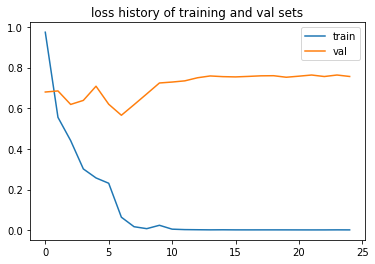

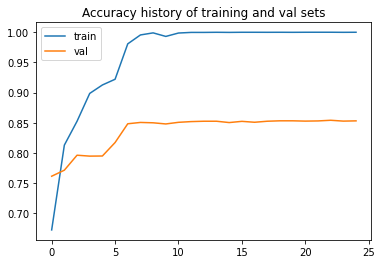

In [107]:
teacher, min_val_loss = train_model([teacher], [train_loader, val_loader], 25, criterion, optimizer, scheduler=scheduler)

#### Finetuning all layers of teacher's results

: Test Loss: 5.999e-01: 100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Accuracy of Test set: 0.8433


{'loss': 0.5999316659927368,
 'accuracy': 0.8433,
 'precision': 0.8443640930583717,
 'recall': 0.8432999999999999,
 'f1': 0.8433037228835673}

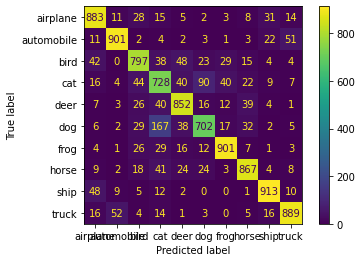

In [108]:
test_results = one_epoch([teacher], test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
test_results

: Validation Loss: 5.655e-01: 100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


Accuracy of Validation set: 0.8483


{'loss': 0.5655165312290191,
 'accuracy': 0.8483,
 'precision': 0.8494300358739748,
 'recall': 0.8478606138591583,
 'f1': 0.8481467767353317}

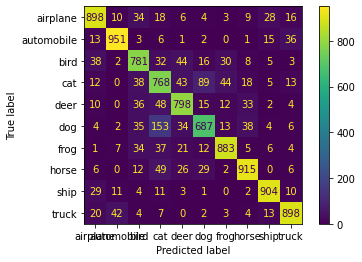

In [109]:
val_results = one_epoch([teacher], val_loader, criterion, train=False, set_name='Validation', metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
val_results

: Train Loss: 1.493e-02: 100%|██████████| 157/157 [00:12<00:00, 12.46it/s]


Accuracy of Train set: 0.996875


{'loss': 0.01492822780534625,
 'accuracy': 0.996875,
 'precision': 0.9968730054975147,
 'recall': 0.9968803376460864,
 'f1': 0.9968748827909529}

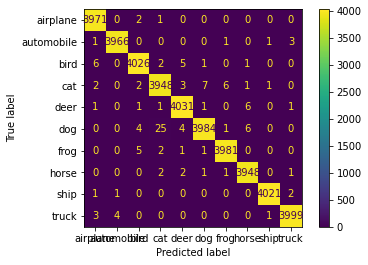

In [110]:
train_results = one_epoch([teacher], train_loader, criterion, train=False, set_name='Train', metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
train_results

As we fine-tuned all layers of the teacher, we can see that it almost overfits completely to the training data. This is because we are using a small dataset and the teacher is very complex. Of course with using a regularization method, we could prevent overfitting.  

You can also note how more time consuming it is to train the teacher with all layers fine-tuned due to the long backpropagation chain.